In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from data_utils import build_xy_grid

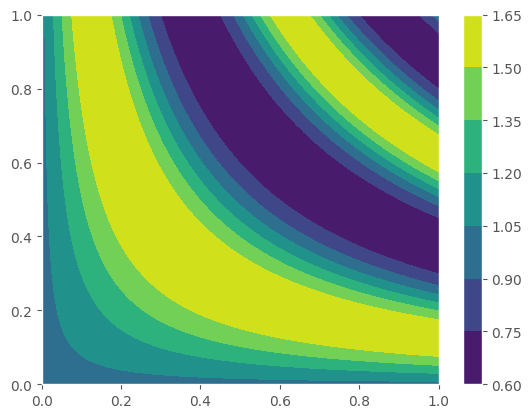

In [3]:
def a(x):
    return jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

vec_a = jax.jit(jax.vmap(a))

fine_grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(fine_grid,fine_grid)
xy_grid = jnp.vstack([x.flatten(),y.flatten()]).T

plt.tricontourf(xy_grid[:,0],xy_grid[:,1],vec_a(xy_grid))
plt.colorbar()

In [5]:
def darcy_op(k,index):
    gradk = jax.grad(k,argnums = index)
    def agradk(*args):
        return a(args[index])*gradk(*args)
    def darcy_result(*args):
        return jnp.trace(jax.jacfwd(agradk,argnums = index)(*args))
    return darcy_result

In [244]:
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],50,50)
xy_full = jnp.vstack([xy_bdy,xy_int])
k_u = get_gaussianRBF(0.2)
#k_f = get_gaussianRBF(0.05)

# KF = jnp.block([
#     [vec_kf(xy_bdy,xy_bdy),vec_kf(xy_bdy,xy_int)],
#     [vec_kf(xy_int,xy_bdy),vec_kf(xy_int,xy_int)]]
#     )

In [184]:
def u_true(x):
    return (jnp.exp(x[0] - x[1]) + jnp.sin(jnp.pi*(x[0]-x[1])))*(jnp.sin(2*jnp.pi*x[0])*jnp.sin(jnp.pi*x[1]))

uvals_true = jax.vmap(u_true)(xy_int)
f = jax.vmap(darcy_op(u_true,index = 0))(xy_int)

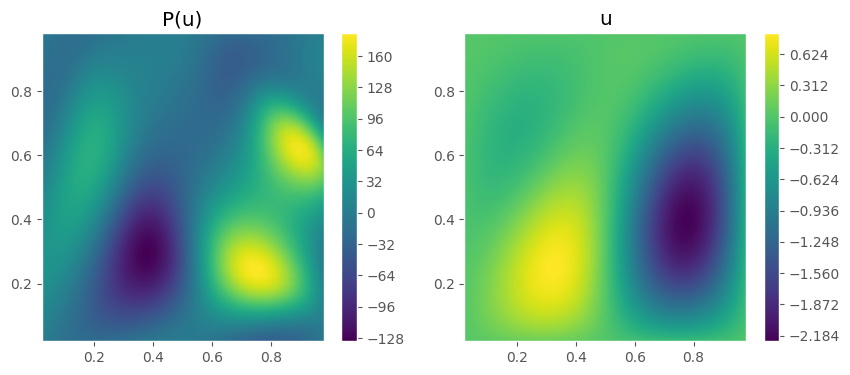

In [185]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("P(u)")
plt.tricontourf(xy_int[:,0],xy_int[:,1],f,500)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('u')
plt.tricontourf(xy_int[:,0],xy_int[:,1],uvals_true,500)
plt.colorbar()
plt.show()

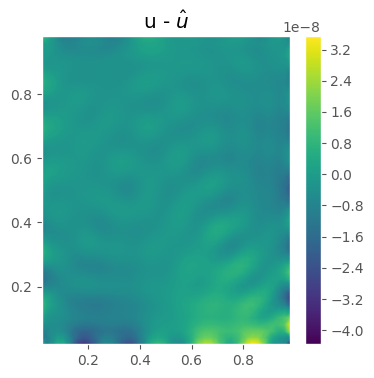

In [187]:
from jax.scipy.linalg import cho_factor,cho_solve
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],50,50)

k_u = get_gaussianRBF(0.2)

operators = (eval_k,darcy_op)
point_blocks = (xy_bdy,xy_int)
Kphiphi_blocks = [
    [
        make_block(k_u,L,R)(left_points,right_points) 
        for R,right_points in zip(operators,point_blocks)] for L,left_points in zip(operators,point_blocks)
]
Kphiphi = jnp.block(Kphiphi_blocks)
rhs = jnp.hstack([jnp.zeros(len(xy_bdy)),f])

num_refinements = 4
chol = cho_factor(Kphiphi + 1e-10 * diagpart(Kphiphi))

residual_norms = []
alpha = cho_solve(chol,rhs)
alpha0 = alpha.copy()
residual = rhs - Kphiphi@alpha
for i in range(num_refinements):
    alpha = alpha + cho_solve(chol,residual)
    residual = rhs - Kphiphi@alpha
    residual_norms.append(jnp.linalg.norm(residual))

K_xPhi = jnp.hstack([
        make_block(k_u,eval_k,R)(xy_int,right_points) 
        for R,right_points in zip(operators,point_blocks)
])
u = K_xPhi@alpha

plt.figure(figsize=(4,4))
plt.title("u - $\\hat u$")
plt.tricontourf(xy_int[:,0],xy_int[:,1],u - uvals_true,500)
plt.colorbar()
plt.show()

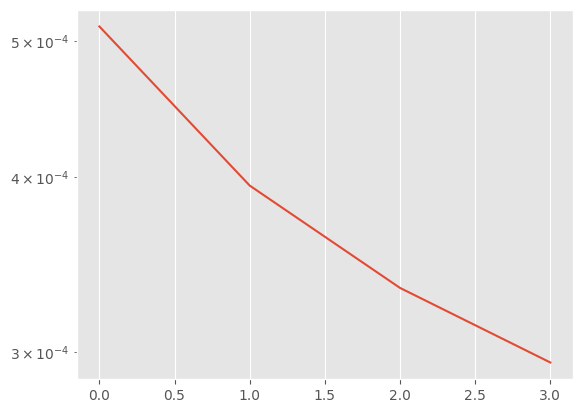

In [161]:
plt.plot(residual_norms)
plt.yscale("log")

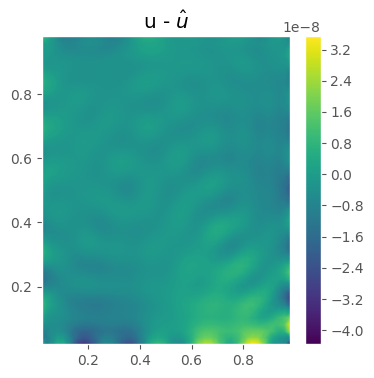

In [162]:
u = K_xPhi@alpha

plt.figure(figsize=(4,4))
plt.title("u - $\\hat u$")
plt.tricontourf(xy_int[:,0],xy_int[:,1],u - uvals_true,500)
plt.colorbar()
plt.show()

In [163]:
jnp.linalg.norm(Kphiphi@alpha - rhs)

Array(0.00029476, dtype=float64)

In [164]:
jnp.linalg.norm(Kphiphi@alpha0 - rhs)

Array(0.00090973, dtype=float64)

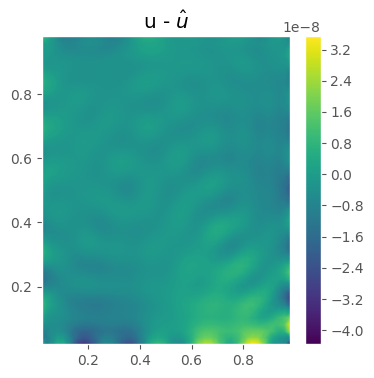

In [166]:
plt.figure(figsize=(4,4))
plt.title("u - $\\hat u$")
plt.tricontourf(xy_int[:,0],xy_int[:,1],u - uvals_true,500)
plt.colorbar()
plt.show()

In [208]:
from jax.scipy.linalg import cho_factor,cho_solve

def get_darcy_solver(
    a:callable,
    num_grid = 50,
    k_u = get_gaussianRBF(0.2),
    nugget = 2e-10,
    num_refinements = 5,
):
    def darcy_op(k,index):
        gradk = jax.grad(k,argnums = index)
        def agradk(*args):
            return a(args[index])*gradk(*args)
        def darcy_result(*args):
            return jnp.trace(jax.jacfwd(agradk,argnums = index)(*args))
        return darcy_result
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid,num_grid)

    operators = (eval_k,darcy_op)
    point_blocks = (xy_bdy,xy_int)
    Kphiphi_blocks = [
        [
            make_block(k_u,L,R)(left_points,right_points) 
            for R,right_points in zip(operators,point_blocks)] for L,left_points in zip(operators,point_blocks)
    ]
    Kphiphi = jnp.block(Kphiphi_blocks)
    num_refinements = 4
    chol = cho_factor(Kphiphi + nugget * diagpart(Kphiphi))
    def solve_darcy(f):
        fvals = jax.vmap(f)(xy_int)
        rhs = jnp.hstack([jnp.zeros(len(xy_bdy)),fvals])
        residual_norms = []
        alpha = cho_solve(chol,rhs)
        residual = rhs - Kphiphi@alpha
        for i in range(num_refinements):
            alpha = alpha + cho_solve(chol,residual)
            residual = rhs - Kphiphi@alpha
            residual_norms.append(jnp.linalg.norm(residual))

        def u(x):
            kxphi = jnp.hstack([
                jax.vmap(R(k_u,1),in_axes = (None,0))(x,right_points)
                for R,right_points in zip(operators,point_blocks)
            ])
            return jnp.dot(kxphi,alpha)
        return u
    return solve_darcy

In [230]:
solver = get_darcy_solver(a)
u_func = solver(lambda x:darcy_op(u_true,index = 0)(x))

In [231]:
def u_true(x):
    return (jnp.exp(x[0] - x[1]) + jnp.sin(jnp.pi*(x[0]-x[1])))*(jnp.sin(2*jnp.pi*x[0])*jnp.sin(jnp.pi*x[1]))

uvals_true = jax.vmap(u_true)(xy_int)
f = jax.vmap(darcy_op(u_true,index = 0))(xy_int)

def u_true(x):
    return (jnp.exp(x[0] - x[1]) + jnp.sin(jnp.pi*(x[0]-x[1])))*(jnp.sin(2*jnp.pi*x[0])*jnp.sin(jnp.pi*x[1]))

uvals_true = jax.vmap(u_true)(xy_int)
f = jax.vmap(darcy_op(u_true,index = 0))(xy_int)

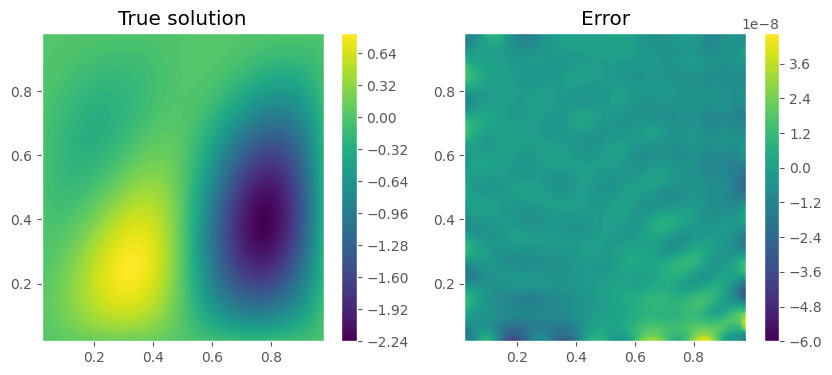

In [243]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("True solution")
plt.tricontourf(xy_int[:,0],xy_int[:,1],jax.vmap(u_true)(xy_int),100)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Error")
plt.tricontourf(xy_int[:,0],xy_int[:,1],jax.vmap(u_func)(xy_int)-jax.vmap(u_true)(xy_int),100)
plt.colorbar()
plt.show()

In [332]:
from jax.scipy.linalg import solve_triangular

def sample_gp_function(key,kernel,num_grid = 100,bounds = jnp.array([0,1])):
    grid = jnp.linspace(bounds[0],bounds[1],num_grid)
    x,y = jnp.meshgrid(grid,grid)
    xy_grid = jnp.vstack([x.flatten(),y.flatten()]).T
    vec_kf = vectorize_kfunc(kernel)
    Kf = vec_kf(xy_grid,xy_grid)
    fChol = cho_factor(Kf+1e-8*diagpart(Kf))
    f_alpha = solve_triangular(fChol[0],jax.random.normal(key,(len(Kf),)))
    def f(x):
        return jnp.dot(f_alpha,jax.vmap(kernel,in_axes = (None,0))(x,xy_grid))
    return f

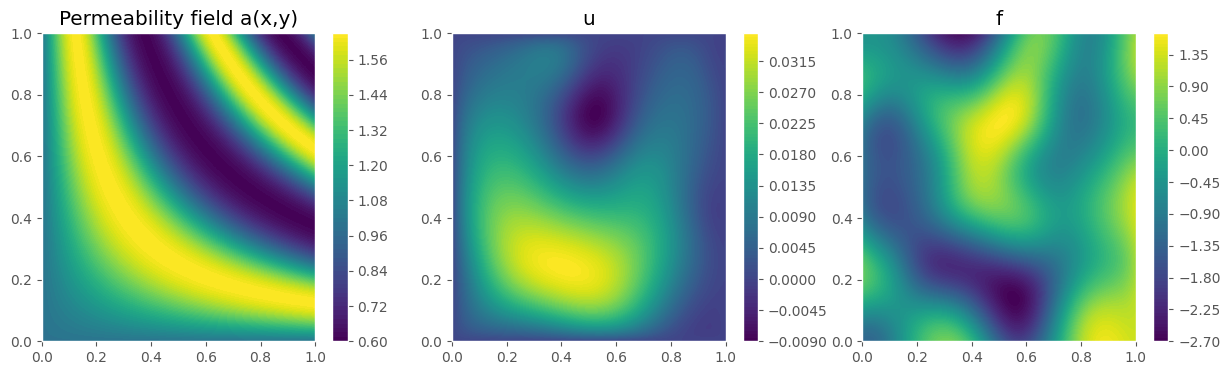

In [340]:
k_f = get_gaussianRBF(0.15)
f = sample_gp_function(jax.random.PRNGKey(32),k_f)
u = solver(f)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Permeability field a(x,y)")
plt.tricontourf(xy_grid[:,0],xy_grid[:,1],jax.vmap(a)(xy_grid),100)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("u")
plt.tricontourf(xy_grid[:,0],xy_grid[:,1],jax.vmap(u)(xy_grid),100)
plt.colorbar()
plt.subplot(1,3,3)
plt.title("f")
plt.tricontourf(xy_grid[:,0],xy_grid[:,1],jax.vmap(f)(xy_grid),100)
plt.colorbar()
